In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('./data/paper.mcstyle')
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from ili.embedding import FCN


import yaml

from CASBI.generator.fff.fff_model import FreeFormFlow
from CASBI.utils.create_dataframe import rescale


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


# CNN

In [2]:
test_number = '28'
with open(f'../../data/tuning/test_{test_number}/hyperparameters.yaml', 'r') as file:
    # Load the contents of the file
    hyperparameters = yaml.safe_load(file)

Flow = FreeFormFlow(dim = 2, 
                    cond_dim = hyperparameters['cond_dim'],
                    hidden_dim = hyperparameters['hidden_dim'],
                    latent_dim = 2,
                    n_SC_layer = hyperparameters['n_SC_layer'],
                    beta = hyperparameters['beta'],
                    device = 'cuda:0'
                    )
Flow.load_state_dict(torch.load(f'../../data/tuning/test_{test_number}/snapshot.pth'))


data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
data = rescale(data, mean_and_std_path='../../data/preprocess/mean_and_std.parquet', scale_observations=True, scale_parameter=True, inverse=True)
min_feh, max_feh = min(data['feh']), max(data['feh'])
min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])
data =  data.drop(['gas_log10mass', 'a','redshift', 'mean_metallicity', 'std_metallicity','mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
conditions = data[data.columns.difference(['feh', 'ofe', 'Galaxy_name'], sort=False)].drop_duplicates()

n_halos=3
def simulator(theta, model=Flow, n_halos=n_halos, min_feh=min_feh, max_feh=max_feh, min_ofe=min_ofe, max_ofe=max_ofe):
    with torch.no_grad():
        model.eval()
        if len(theta.shape) == 1:
            for i in range(n_halos):
                if i==0:
                    cond = theta[i::n_halos].repeat(500, 1)
                    halo = model.sample(500, cond=cond)
                else:
                    cond = theta[i::n_halos].repeat(500, 1)
                    halo = torch.vstack((halo, model.sample(500, cond=cond))).to('cpu')
            batch_halos, _, _ = np.histogram2d(halo[:, 0], halo[:, 1], bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
            batch_halos = np.expand_dims(batch_halos, axis=0)
            batch_halos = torch.log1p(torch.from_numpy(batch_halos+1e-6))
        
            
        else:
            batch_halos = torch.zeros(theta.shape[0], 1, 64 , 64)
            for n, batch in enumerate(theta):
                for i in range(n_halos):
                    if i==0:
                        cond = batch[i::n_halos].repeat(500, 1)
                        halo = model.sample(500, cond=cond)
                    else:
                        cond = batch[i::n_halos].repeat(500, 1)
                        halo = torch.vstack((halo, model.sample(500, cond=cond))).to('cpu')
                bh, _, _ = np.histogram2d(halo[:, 0], halo[:, 1], bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
                bh = np.expand_dims(bh, axis=0)
                batch_halos[n] = torch.log1p(torch.from_numpy(bh + 1e-6))
        
        return batch_halos
 
minimum_theta = [conditions[col].values.min() for col in conditions.columns]   
maximum_theta = [conditions[col].values.max() for col in conditions.columns]       
minimum_theta = np.array(minimum_theta)
maximum_theta = np.array(maximum_theta)
def repeat_array(arr, repetitions):
    return np.repeat(arr, repetitions)
repeat_minimum_theta = repeat_array(minimum_theta, n_halos)
repeat_maximum_theta = repeat_array(maximum_theta, n_halos) 

prior = ili.utils.Uniform(low=repeat_minimum_theta, high=repeat_maximum_theta, device=device)

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [4]:
# instantiate a CNN embedding network
embedding_net = ConvNet()
# embdedding_net =  FCN(n_hidden=[256, 256, 256, 256], act_fn="SiLU")

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=5,
                           embedding_net=embedding_net),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=5,
                           embedding_net=embedding_net),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=5,
                           embedding_net=embedding_net),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-4,
    'stop_after_epochs': 50
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=embedding_net,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [5]:
galaxies = data['Galaxy_name'].sample(3)
theta_0 =  data[data['Galaxy_name'].isin(galaxies)].drop(['feh', 'ofe', 'Galaxy_name'], axis=1).drop_duplicates().values.T.reshape(-1)
galaxy_data = data[data['Galaxy_name'].isin(galaxies)].values
histogram_galaxy, _, _ = np.histogram2d(galaxy_data[:, 0], galaxy_data[:, 1], bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
x_0 =  np.expand_dims(np.log10(histogram_galaxy + 1e-6 +1), axis=0)
data = data[~data['Galaxy_name'].isin(galaxies)]

In [6]:
import numpy as np
import pandas as pd
from multiprocessing import Pool
N=5_000
def process_sample(i):
    galaxies = data['Galaxy_name'].drop_duplicates().sample(n_halos, random_state=i)
    parameters =  data[data['Galaxy_name'].isin(galaxies)].drop(['feh', 'ofe', 'Galaxy_name'], axis=1).drop_duplicates().values.T.reshape(-1)
    galaxy_data = data[data['Galaxy_name'].isin(galaxies)].values
    histogram_galaxy, _, _ = np.histogram2d(galaxy_data[:, 0], galaxy_data[:, 1], bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
    sim_data =  np.expand_dims(np.log10(histogram_galaxy + 1e-6 +1), axis=0)
    return parameters, sim_data

# Create a pool of workers
with Pool() as pool:
    # Map the function to the data
    results = pool.map(process_sample, range(N))

# Unpack the results
theta, x = zip(*results)

# Convert to numpy arrays
theta = torch.from_numpy(np.array(theta)).float()
x = torch.from_numpy(np.array(x)).float()

In [7]:
l = [i for i in range(len(theta)) if torch.equal(theta[i], torch.from_numpy(theta_0))]
print(l)

[]


In [8]:
loader = NumpyLoader(x=x, theta=theta)
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 3.


 Training neural network. Epochs trained: 1Training neural network. Epochs trained: 2Training neural network. Epochs trained: 3Training neural network. Epochs trained: 4Training neural network. Epochs trained: 5Training neural network. Epochs trained: 6Training neural network. Epochs trained: 7Training neural network. Epochs trained: 8Training neural network. Epochs trained: 9Training neural network. Epochs trained: 10Training neural network. Epochs trained: 11Training neural network. Epochs trained: 12Training neural network. Epochs trained: 13Training neural network. Epochs trained: 14Training neural network. Epochs trained: 15Training neural network. Epochs trained: 16Training neural network. Epochs trained: 17Training neural network. Epochs trained: 18Training neural network. Epochs trained: 19Training neural network. Epochs trained: 20Training neural network. Epochs trained: 21Training neural network. Epochs trained: 22Training neural network. Epochs trained: 23Training neural net

INFO:root:Training model 2 / 3.


 Training neural network. Epochs trained: 1Training neural network. Epochs trained: 2Training neural network. Epochs trained: 3Training neural network. Epochs trained: 4Training neural network. Epochs trained: 5Training neural network. Epochs trained: 6Training neural network. Epochs trained: 7Training neural network. Epochs trained: 8Training neural network. Epochs trained: 9Training neural network. Epochs trained: 10Training neural network. Epochs trained: 11Training neural network. Epochs trained: 12Training neural network. Epochs trained: 13Training neural network. Epochs trained: 14Training neural network. Epochs trained: 15Training neural network. Epochs trained: 16Training neural network. Epochs trained: 17Training neural network. Epochs trained: 18Training neural network. Epochs trained: 19Training neural network. Epochs trained: 20Training neural network. Epochs trained: 21Training neural network. Epochs trained: 22Training neural network. Epochs trained: 23Training neural net

INFO:root:Training model 3 / 3.


 Training neural network. Epochs trained: 1Training neural network. Epochs trained: 2Training neural network. Epochs trained: 3Training neural network. Epochs trained: 4Training neural network. Epochs trained: 5Training neural network. Epochs trained: 6Training neural network. Epochs trained: 7Training neural network. Epochs trained: 8Training neural network. Epochs trained: 9Training neural network. Epochs trained: 10Training neural network. Epochs trained: 11Training neural network. Epochs trained: 12Training neural network. Epochs trained: 13Training neural network. Epochs trained: 14Training neural network. Epochs trained: 15Training neural network. Epochs trained: 16Training neural network. Epochs trained: 17Training neural network. Epochs trained: 18Training neural network. Epochs trained: 19Training neural network. Epochs trained: 20Training neural network. Epochs trained: 21Training neural network. Epochs trained: 22Training neural network. Epochs trained: 23Training neural net

INFO:root:It took 431.0804145336151 seconds to train models.


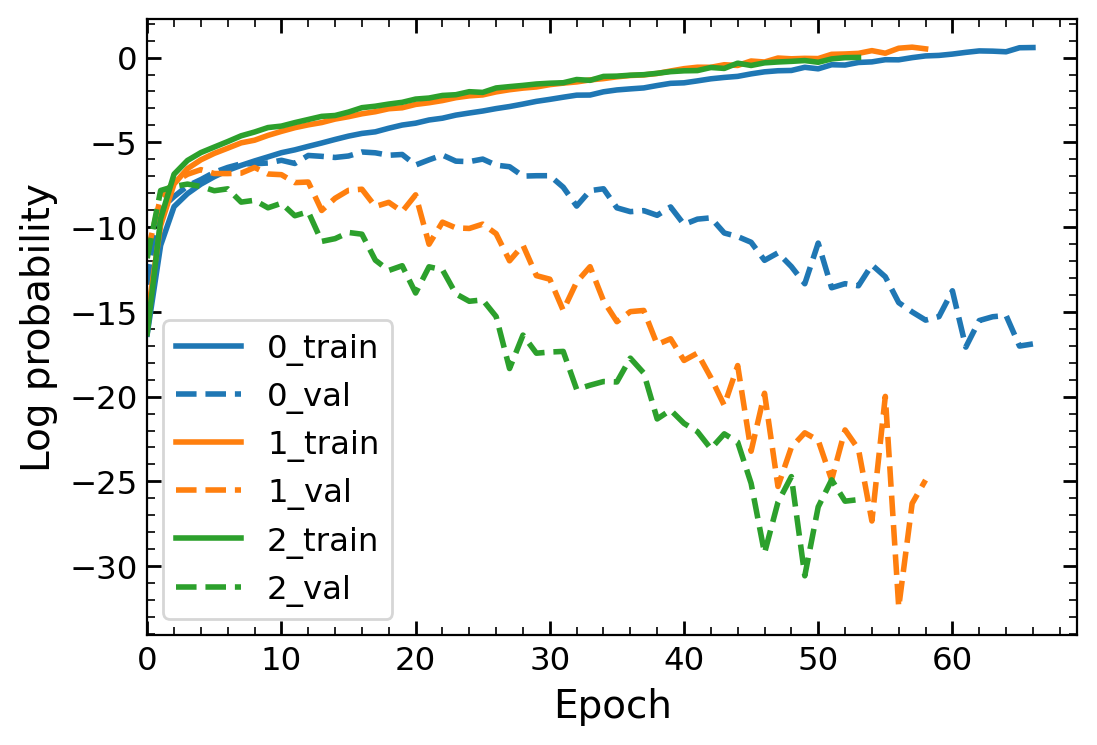

In [9]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [10]:
# choose a random input
# ind = np.random.randint(len(theta))
# x_test = torch.Tensor(x[ind]).to(device)
x_test = torch.from_numpy(x_0).to(device)

# generate samples from the posterior using accept/reject sampling
samples = posterior_ensemble.sample((5_000,), x_test)
# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, x_test)

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()
# theta = theta.cpu().numpy()

Drawing 3223 posterior samples:   0%|          | 0/3223 [00:00<?, ?it/s]

Drawing 1294 posterior samples:   0%|          | 0/1294 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

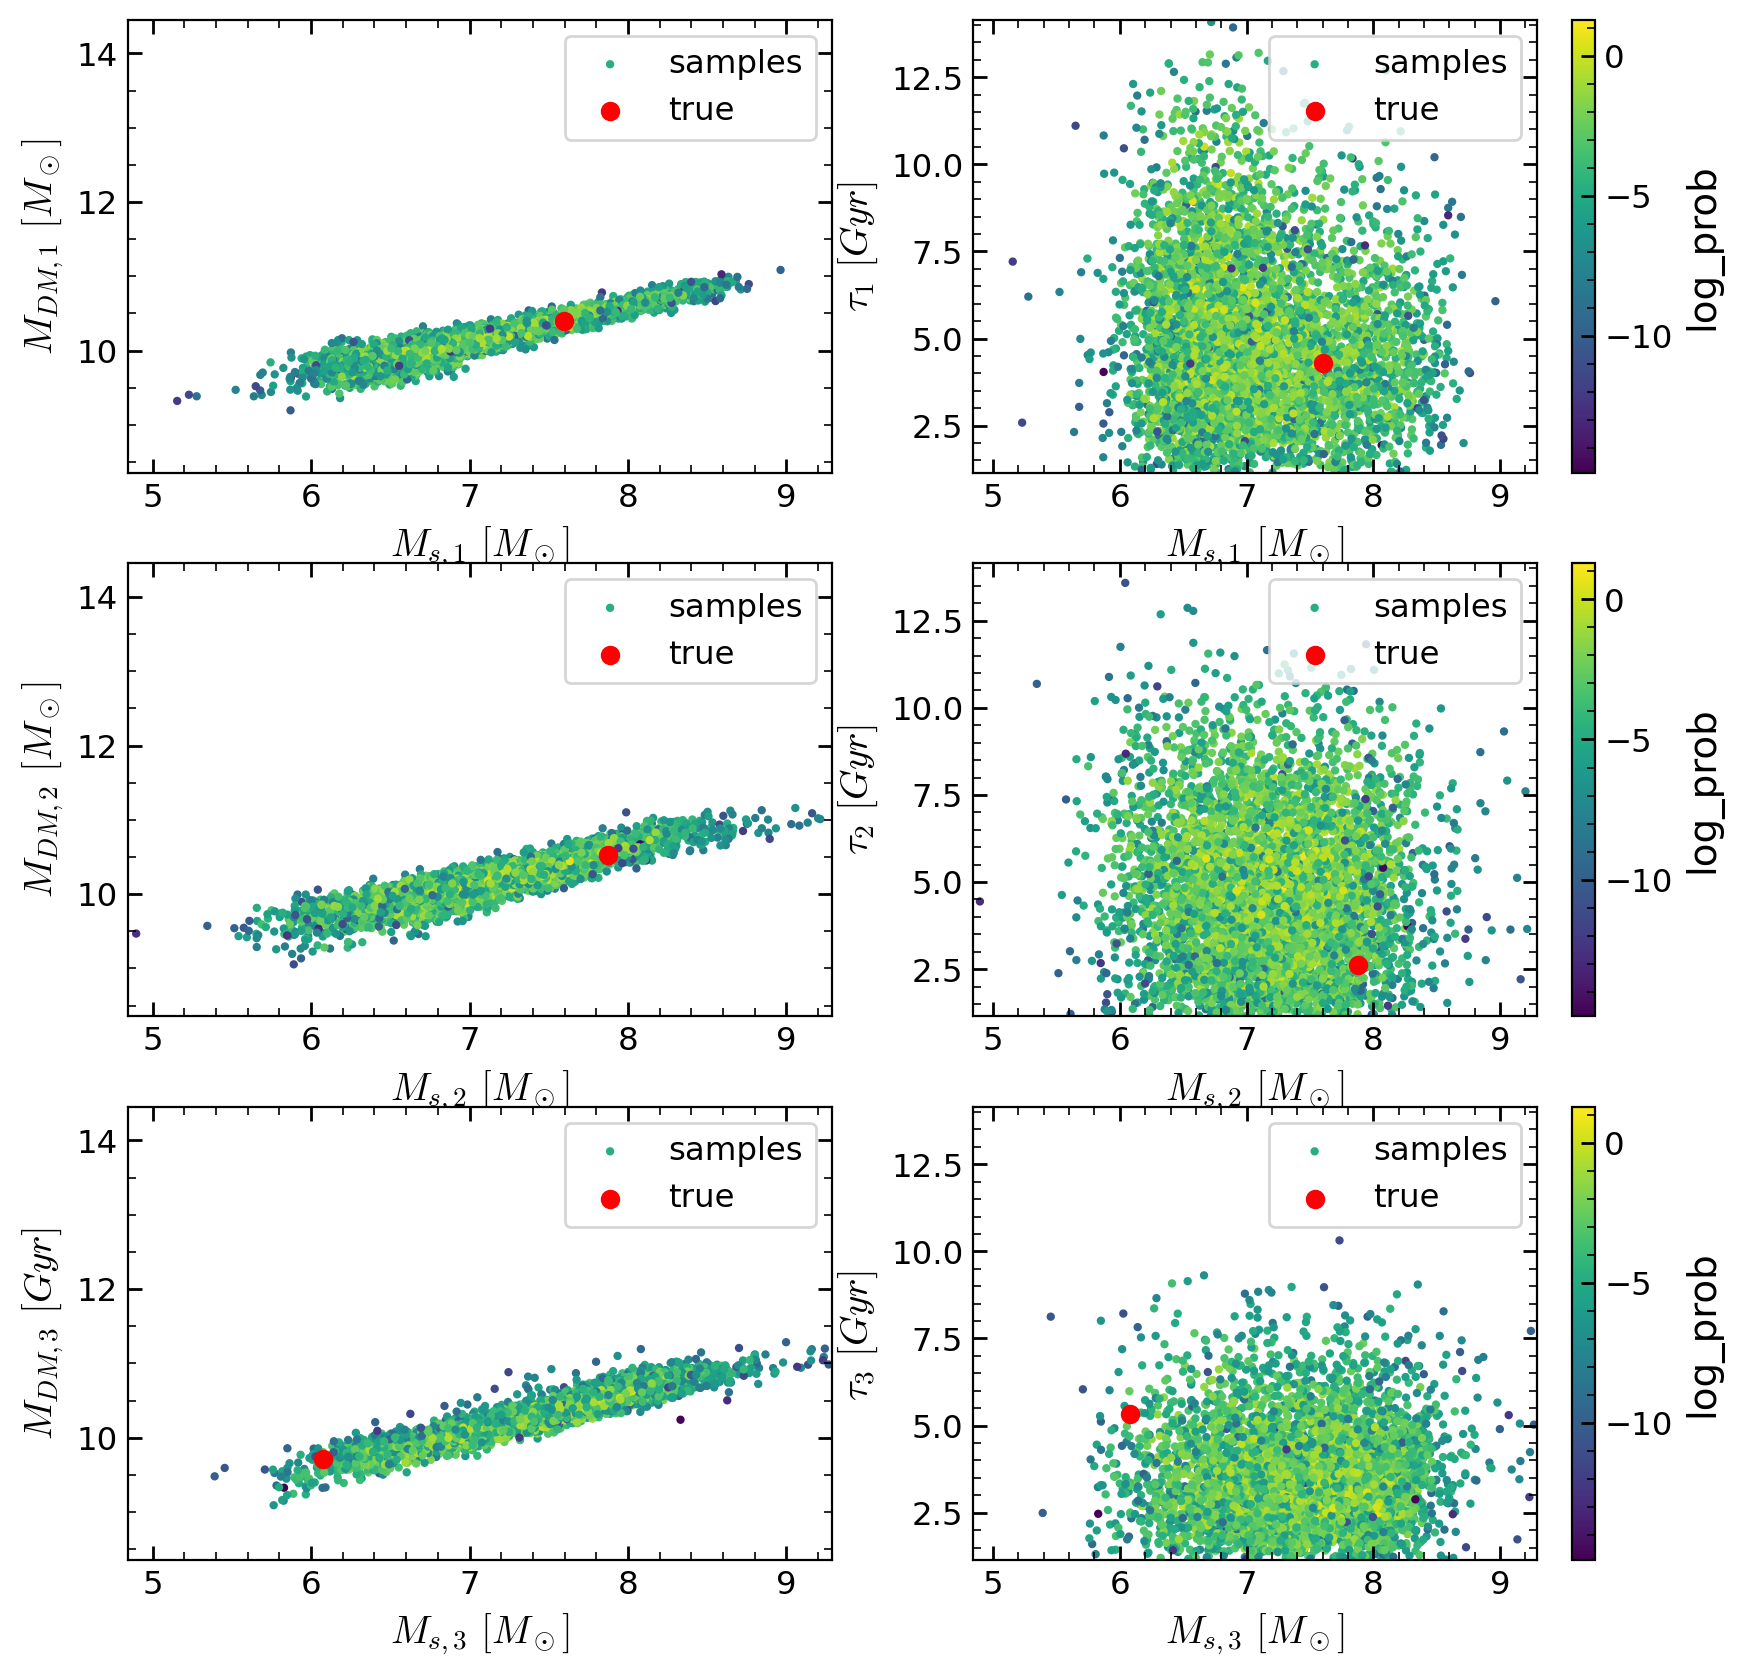

In [11]:
# plot the posterior samples and the true value
labels = [r'$M_{s, 1}\ [M_\odot]$', r'$M_{s, 2}\ [M_\odot]$', r'$M_{s, 3}\ [M_\odot]$', r'$M_{DM, 1}\ [M_\odot]$', r'$M_{DM, 2}\ [M_\odot]$', r'$M_{DM, 3}\ [Gyr]$', r'$\tau_{1}\ [Gyr]$', r'$\tau_{2}\ [Gyr]$', r'$\tau_{3}\ [Gyr]$ ']

fig, axs = plt.subplots(n_halos, 2, figsize=(10,10), )
for i in range(n_halos):
    axs[i, 0].scatter(samples[:, i], samples[:, i+n_halos], c=log_prob, s=4, label='samples')
    axs[i, 0].scatter(theta_0[i], theta_0[i+n_halos], c='r', label='true')
    axs[i, 0].set_xlim(repeat_minimum_theta[i], repeat_maximum_theta[i])
    axs[i, 0].set_ylim(repeat_minimum_theta[i+n_halos], repeat_maximum_theta[i+n_halos])
    axs[i, 0].set_xlabel(labels[i])
    axs[i, 0].set_ylabel(labels[i+n_halos])
    axs[i, 0].legend()
    
    
    scatter = axs[i, 1].scatter(samples[:, i], samples[:, i+2*n_halos], c=log_prob, s=4, label='samples')
    axs[i, 1].scatter(theta_0[i], theta_0[i+2*n_halos], c='r', label='true')
    axs[i, 1].set_xlim(repeat_minimum_theta[i], repeat_maximum_theta[i])
    axs[i, 1].set_ylim(repeat_minimum_theta[i+2*n_halos], repeat_maximum_theta[i+2*n_halos])
    axs[i, 1].set_xlabel(labels[i])
    axs[i, 1].set_ylabel(labels[i+2*n_halos])
    fig.colorbar(scatter, ax=axs[i, 1], label='log_prob')
    axs[i, 1].legend()

Drawing 6492 posterior samples:   0%|          | 0/6492 [00:00<?, ?it/s]

Drawing 2586 posterior samples:   0%|          | 0/2586 [00:00<?, ?it/s]

Drawing 922 posterior samples:   0%|          | 0/922 [00:00<?, ?it/s]

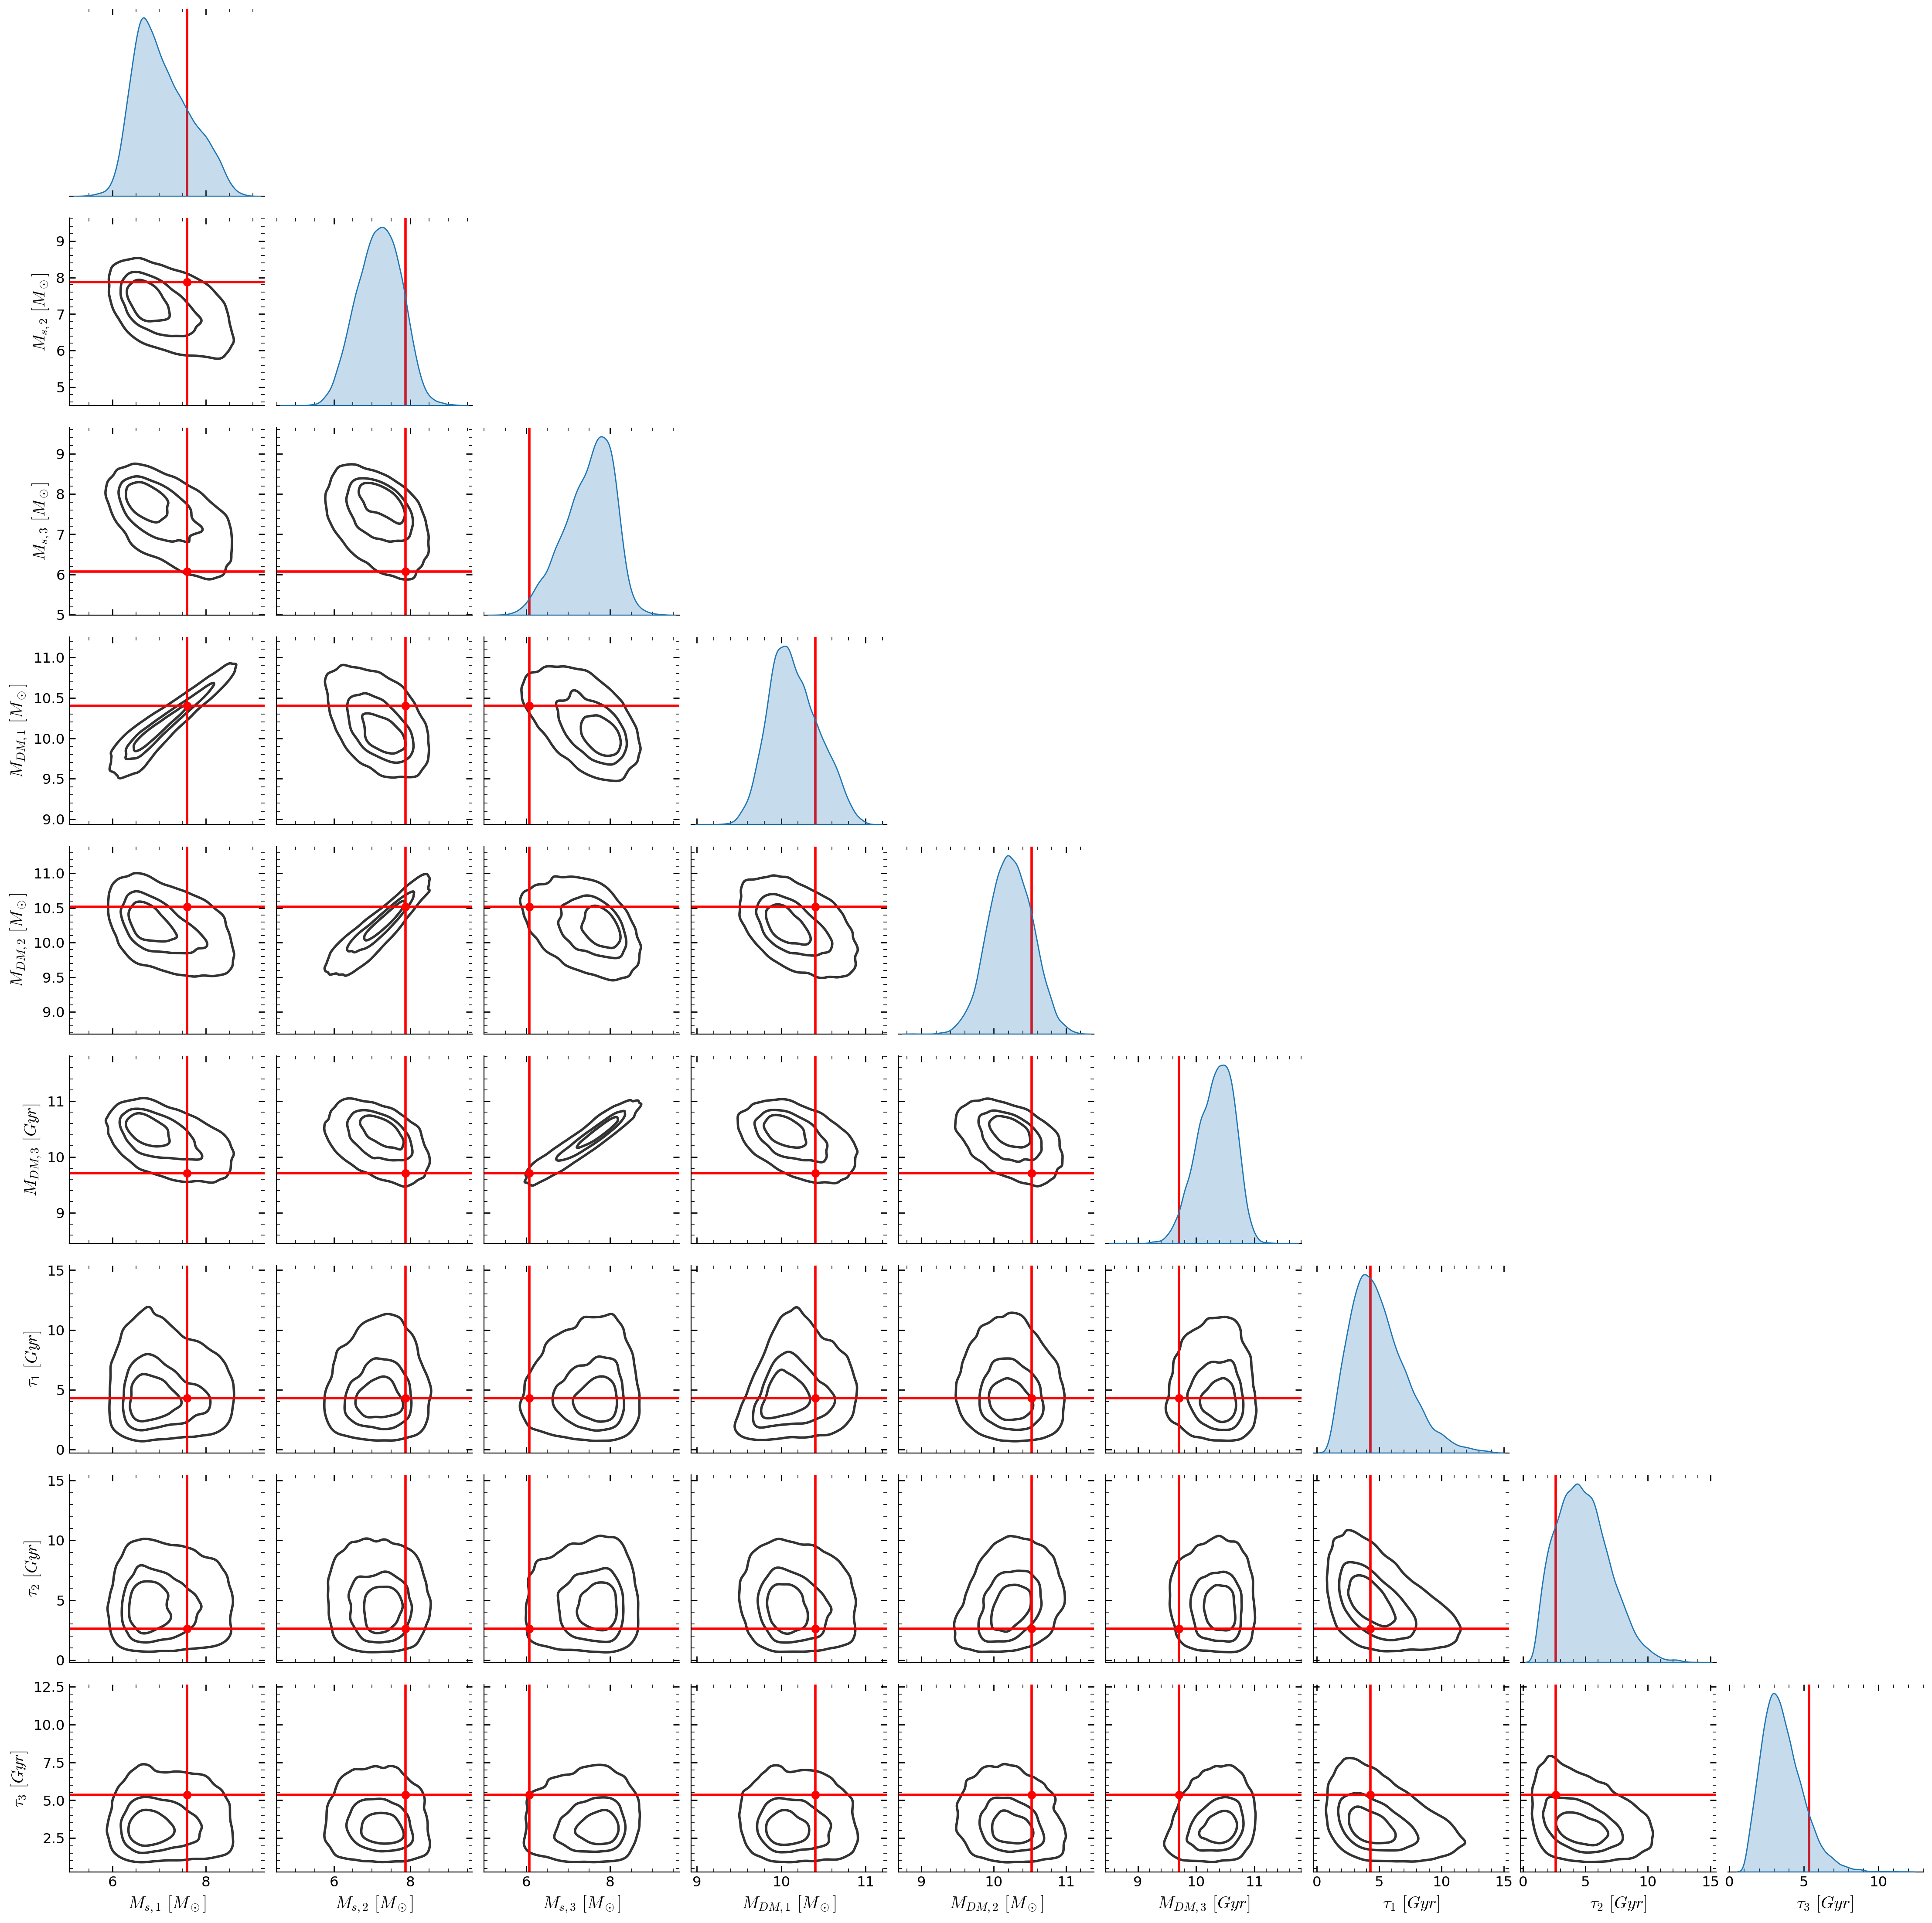

In [12]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=10_000, sample_method='direct', 
    labels = [r'$M_{s, 1}\ [M_\odot]$', r'$M_{s, 2}\ [M_\odot]$', r'$M_{s, 3}\ [M_\odot]$', r'$M_{DM, 1}\ [M_\odot]$', r'$M_{DM, 2}\ [M_\odot]$', r'$M_{DM, 3}\ [Gyr]$', r'$\tau_{1}\ [Gyr]$', r'$\tau_{2}\ [Gyr]$', r'$\tau_{3}\ [Gyr]$ '],
    out_dir=None
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x_0, theta_fid=theta_0,
)

In [13]:
# calculate and plot the rank statistics to describe univariate posterior coverage
metric = PosteriorCoverage(
    num_samples=5000, sample_method='direct',
    labels=labels, plot_list = ["coverage", "histogram", "predictions", "tarp"]
)
fig = metric(
    posterior=posterior_ensemble,
    x=x[::8], theta=theta[::8]
)

 52%|█████▏    | 326/625 [00:38<00:34,  8.61it/s]

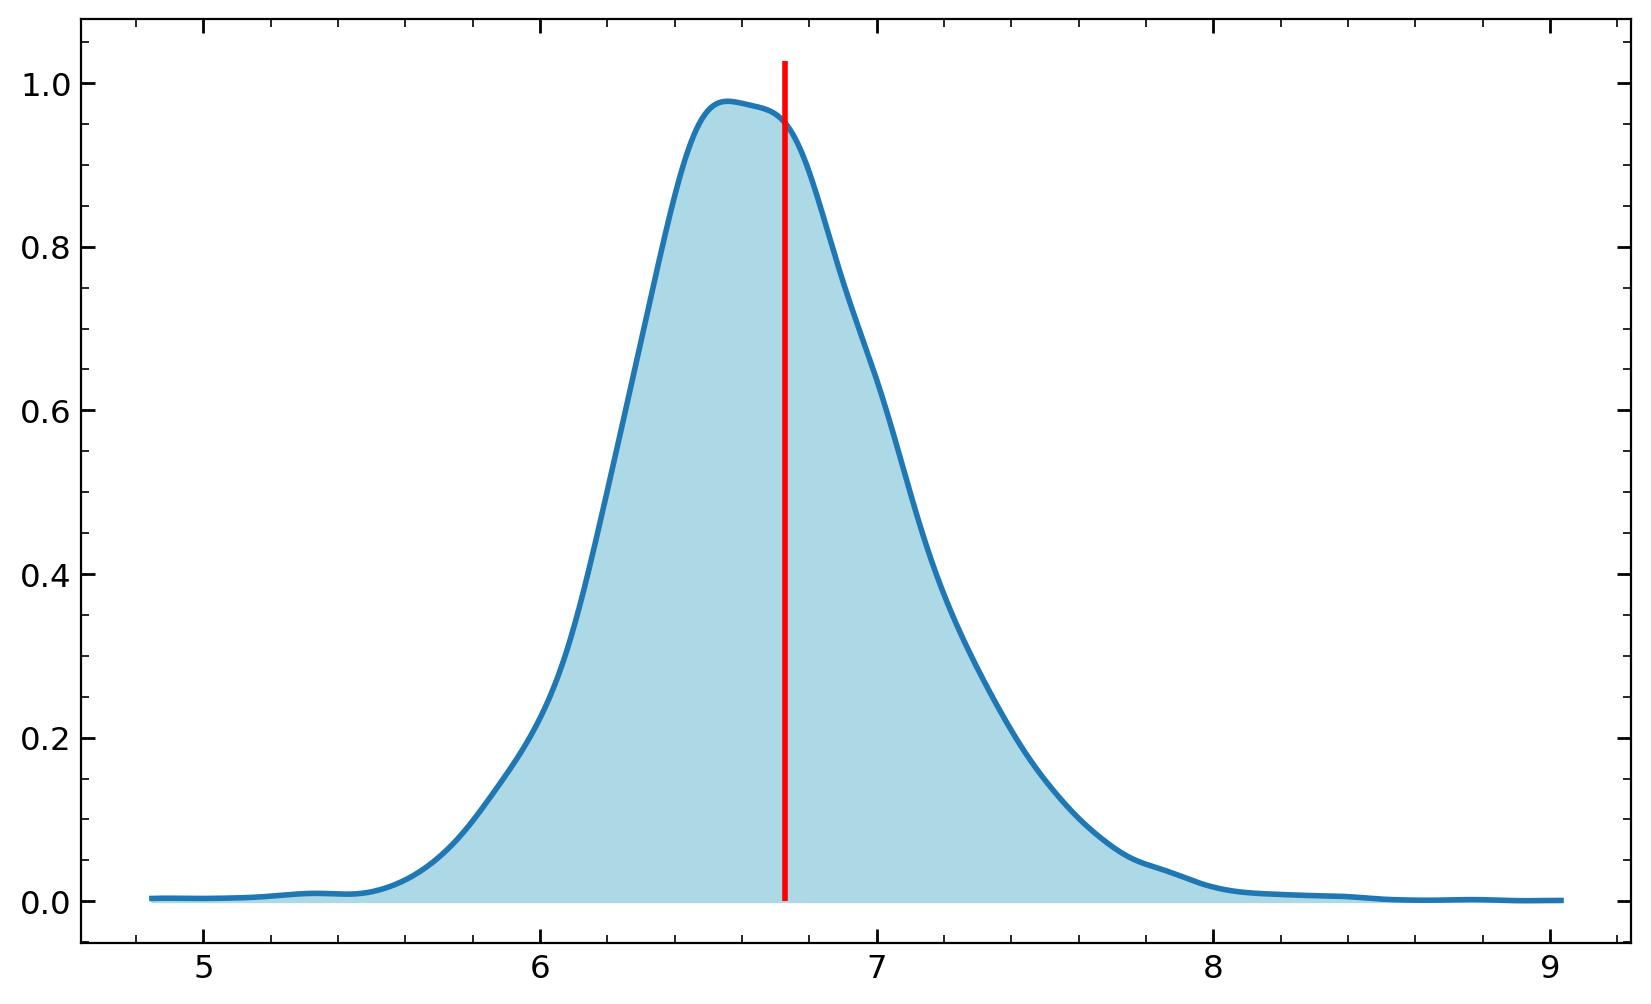

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming `data` is your array of data points
data = samples[:,1]

# Calculate the KDE
kde = gaussian_kde(data)

# Create an array of x values to plot
x = np.linspace(min(data), max(data), 1000)

# Plot the KDE
plt.plot(x, kde(x), label='KDE')
plt.fill_between(x, kde(x), color='lightblue')

plt.vlines(theta_0[1], 0, plt.gca().get_ylim()[1], color='red', label='True value')